In [1]:
import numpy as np
import cv2
import os
import pickle
import random
import shutil
import sys
import time
import zipfile
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import nn
import random
import torch

In [2]:
import pahaw_loader
from PahawOfflineSimDataset import PahawOfflineSimDataset, patches_per_image, patch_generator

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
subjects_pd_status_years, subjects_tasks = pahaw_loader.load()

Archivo no encontrado: PaHaW/PaHaW_public/00017/00017__8_1.svc, se omite.
Tarea vacía para Sujeto 17, Tarea 8, se omite.
Archivo no encontrado: PaHaW/PaHaW_public/00027/00027__8_1.svc, se omite.
Tarea vacía para Sujeto 27, Tarea 8, se omite.
Archivo no encontrado: PaHaW/PaHaW_public/00061/00061__1_1.svc, se omite.
Tarea vacía para Sujeto 61, Tarea 1, se omite.
Archivo no encontrado: PaHaW/PaHaW_public/00080/00080__1_1.svc, se omite.
Tarea vacía para Sujeto 80, Tarea 1, se omite.
Archivo no encontrado: PaHaW/PaHaW_public/00089/00089__1_1.svc, se omite.
Tarea vacía para Sujeto 89, Tarea 1, se omite.


In [5]:
task0 = subjects_tasks[1][5]
task0.plot_task(1)
cv2.imwrite("results/presiones.png", task0.getImage())

Altitudes [501]: [0.12, 0.12, 0.32, 0.32, 0.32, 0.32, 0.06, 0.06, 0.06, 0.06]
Presones [501]: [0.0, 0.12169735788630905, 0.24499599679743794, 0.3434747798238591, 0.41072858286629305, 0.46357085668534825, 0.5148118494795837, 0.5692554043234588, 0.6092874299439551, 0.644515612489992]
Altitudes [216]: [0.0, 0.0, 0.0, 0.0, 0.19642857142857142, 0.19642857142857142, 0.4107142857142857, 0.4107142857142857, 0.4107142857142857, 0.4107142857142857]
Presones [216]: [0.0, 0.08606856309263311, 0.199854121079504, 0.29686360320933625, 0.35667396061269147, 0.40189642596644787, 0.4485776805251641, 0.4733770970094821, 0.49817651349380015, 0.5200583515681984]
Altitudes [85]: [0.0, 0.0, 0.34375, 0.34375, 0.34375, 0.34375, 0.34375, 0.65625, 0.65625, 0.65625]
Presones [85]: [0.0, 0.24176646706586827, 0.4184131736526946, 0.5516467065868264, 0.625, 0.6549401197604791, 0.6758982035928144, 0.7103293413173652, 0.749251497005988, 0.7851796407185628]
Altitudes [535]: [0.3333333333333333, 0.3333333333333333, 0.3333

True

In [5]:
subjects_ids = list(subjects_tasks.keys())
data_label_img = []
for subject_id in subjects_ids:
    for task_number in range(2, 9):
        task = subjects_tasks[subject_id].get(task_number)
        if task is not None:
            data_label_img.append(
                (
                    task,
                    subjects_pd_status_years[subject_id][0]
                 )
            )
pahaw_offline_dataset = PahawOfflineSimDataset(data_label_img, device=device)

In [6]:
def plot_patches(patches: list, npatches_per_plot = 50):
    fig, axes = plt.subplots(1, npatches_per_plot, figsize = (12,4))
    for i in range(len(patches)):
        patch_np = patches[i].squeeze(0).numpy()  # (H, W)

        # Escalar si hace falta (está normalizado o en float)
        patch_uint8 = (patch_np * 255).astype('uint8') if patch_np.max() <= 1 else patch_np.astype('uint8')
        if i < npatches_per_plot:
            axes[i].imshow(patch_uint8, cmap='gray')
            axes[i].axis('off')
        #cv2.imwrite(f"tareas_generadas/patch{i}.png", patch_uint8)
    plt.show("patches_plot.png")

In [8]:
patches, label = pahaw_offline_dataset[0]

torch.Size([1, 672, 4600])


In [14]:
plt.imshow(patches[100].squeeze(0).numpy(), cmap='gray')
plt.show()

IndexError: list index out of range

torch.Size([1, 672, 200])


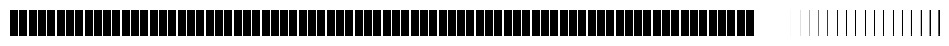

In [27]:
print(patches[0].shape)
plot_patches(patches, 100)